# First Model training (aligned with baseline)

Use the same numeric features and metrics as the logistic regression baseline for apples-to-apples comparison.

## Setup and imports

In [65]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.metrics import balanced_accuracy_score


## Data loading and splits (stratified 60/20/20)

In [66]:
CAT_COLS = [
    "driver_id",
    "constructor_id",
    "circuit_id",
]
NUM_COLS = [
    "grid_position",
    "quali_delta",
    "quali_tm_delta",
    "season_pts_driver",
    "season_pts_team",
    "last_3_avg",
    "is_street_circuit",
    "is_wet",
]
FEATURES = CAT_COLS + NUM_COLS
TARGET = "points_scored"

train_df = pd.read_csv("data/grandprix_features_train.csv")
val_df   = pd.read_csv("data/grandprix_features_val.csv") 
test_df  = pd.read_csv("data/grandprix_features_test.csv")

X_train, y_train = train_df[CAT_COLS + NUM_COLS], train_df[TARGET]
X_val,   y_val   = val_df[CAT_COLS + NUM_COLS],   val_df[TARGET]
X_test,  y_test  = test_df[CAT_COLS + NUM_COLS],  test_df[TARGET]
print(f"Splits -> train: {len(train_df)}, val: {len(val_df)}, test: {len(test_df)}")


Splits -> train: 1176, val: 294, test: 368


## Preprocessing (impute + standardize numeric)

In [67]:
# Match baseline preprocessing: one-hot categorical IDs + imputed/scaled numeric columns
preprocess = ColumnTransformer(
    [
        ("cat", OneHotEncoder(handle_unknown="ignore"), CAT_COLS),
        (
            "num",
            Pipeline(
                [
                    ("imputer", SimpleImputer(strategy="median")),
                    ("scaler", StandardScaler()),
                ]
            ),
            NUM_COLS,
        ),
    ]
)

def to_numpy(matrix):
    return matrix.toarray() if hasattr(matrix, "toarray") else matrix

X_train = to_numpy(preprocess.fit_transform(train_df[FEATURES]))
X_val = to_numpy(preprocess.transform(val_df[FEATURES]))
X_test = to_numpy(preprocess.transform(test_df[FEATURES]))

X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

y_train = train_df[TARGET].values.astype(np.float32)
y_val = val_df[TARGET].values.astype(np.float32)
y_test = test_df[TARGET].values.astype(np.float32)

# Class weighting for imbalance (matches logistic regression class_weight="balanced")
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
pos_weight = torch.tensor(neg / pos, dtype=torch.float32)
print(f"pos_weight: {pos_weight:.3f}")


pos_weight: 0.997


## Dataset and DataLoader

In [68]:
class ArrayDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = ArrayDataset(X_train, y_train)
val_ds = ArrayDataset(X_val, y_val)
test_ds = ArrayDataset(X_test, y_test)

batch_size = 32
generator = torch.Generator().manual_seed(42)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, generator=generator)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)


## Model

In [69]:
input_dim = X_train.shape[1]

class SimplePointsMLP(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        return self.net(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimplePointsMLP(input_dim).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print('Using device:', device)


Using device: cpu


## Training and evaluation helpers

In [70]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1)

        logits = model(X_batch)
        loss = criterion(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y_batch.size(0)
        total_samples += y_batch.size(0)

        with torch.no_grad():
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()
            total_correct += (preds == y_batch).sum().item()

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).unsqueeze(1)

            logits = model(X_batch)
            loss = criterion(logits, y_batch)

            total_loss += loss.item() * y_batch.size(0)
            total_samples += y_batch.size(0)

            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()
            total_correct += (preds == y_batch).sum().item()

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


def collect_predictions(model, dataloader, device):
    model.eval()
    all_probs = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            probs = torch.sigmoid(logits).squeeze(1)

            all_probs.append(probs.cpu())
            all_targets.append(y_batch.cpu())

    probs = torch.cat(all_probs)
    targets = torch.cat(all_targets)
    preds = (probs >= 0.5).float()
    return targets, probs, preds


## Train loop

In [71]:
torch.manual_seed(42)
np.random.seed(42)

num_epochs = 20
train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    train_acc_hist.append(train_acc)
    val_acc_hist.append(val_acc)

    print(
        f"Epoch {epoch:02d} | "
        f"Train Loss: {train_loss:.4f}  Acc: {train_acc:.3f} | "
        f"Val Loss: {val_loss:.4f}  Acc: {val_acc:.3f}"
    )


Epoch 01 | Train Loss: 0.6604  Acc: 0.710 | Val Loss: 0.6122  Acc: 0.748
Epoch 02 | Train Loss: 0.5366  Acc: 0.766 | Val Loss: 0.5100  Acc: 0.769
Epoch 03 | Train Loss: 0.4621  Acc: 0.781 | Val Loss: 0.4931  Acc: 0.779
Epoch 04 | Train Loss: 0.4410  Acc: 0.806 | Val Loss: 0.4920  Acc: 0.782
Epoch 05 | Train Loss: 0.4311  Acc: 0.812 | Val Loss: 0.4948  Acc: 0.779
Epoch 06 | Train Loss: 0.4236  Acc: 0.815 | Val Loss: 0.4931  Acc: 0.782
Epoch 07 | Train Loss: 0.4169  Acc: 0.820 | Val Loss: 0.4957  Acc: 0.782
Epoch 08 | Train Loss: 0.4118  Acc: 0.821 | Val Loss: 0.5009  Acc: 0.776
Epoch 09 | Train Loss: 0.4067  Acc: 0.824 | Val Loss: 0.4966  Acc: 0.779
Epoch 10 | Train Loss: 0.4003  Acc: 0.825 | Val Loss: 0.5017  Acc: 0.776
Epoch 11 | Train Loss: 0.3948  Acc: 0.827 | Val Loss: 0.5041  Acc: 0.772
Epoch 12 | Train Loss: 0.3880  Acc: 0.832 | Val Loss: 0.5076  Acc: 0.776
Epoch 13 | Train Loss: 0.3815  Acc: 0.832 | Val Loss: 0.5070  Acc: 0.769
Epoch 14 | Train Loss: 0.3758  Acc: 0.843 | Val Los

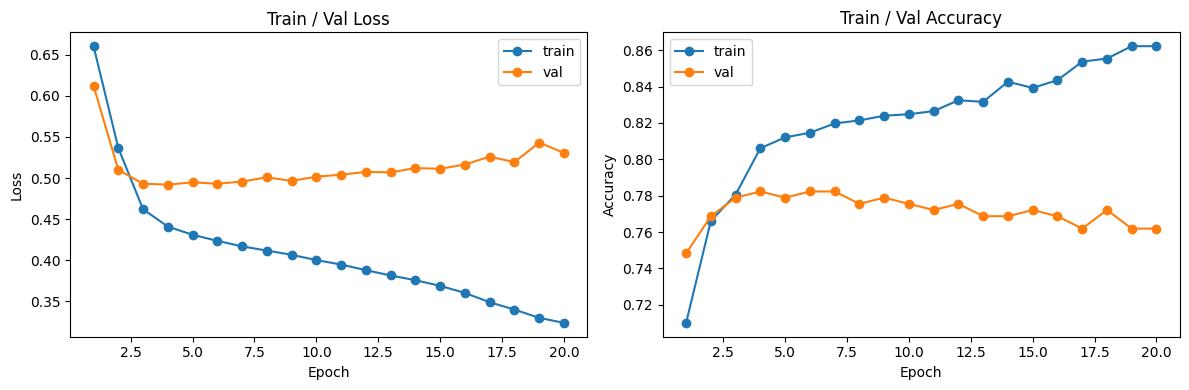

In [72]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_hist, marker="o", label="train")
plt.plot(range(1, num_epochs + 1), val_loss_hist, marker="o", label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train / Val Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_acc_hist, marker="o", label="train")
plt.plot(range(1, num_epochs + 1), val_acc_hist, marker="o", label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train / Val Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


## Test set evaluation (same metrics as baseline)

In [73]:
# Loss/accuracy
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

# Probabilities and class metrics
test_targets, test_probs, test_preds = collect_predictions(model, test_loader, device)

test_targets_np = test_targets.numpy()
test_probs_np = test_probs.numpy()
test_preds_np = test_preds.numpy()


print('Precision:', precision_score(test_targets_np, test_preds_np))
print('Recall:', recall_score(test_targets_np, test_preds_np))
print('F1 (binary):', f1_score(test_targets_np, test_preds_np))
print('F1 (macro):', f1_score(test_targets_np, test_preds_np, average="macro"))
print('Balanced accuracy:', balanced_accuracy_score(test_targets_np, test_preds_np))

Precision: 0.7897727272727273
Recall: 0.7554347826086957
F1 (binary): 0.7722222222222223
F1 (macro): 0.7770685579196217
Balanced accuracy: 0.7771739130434783


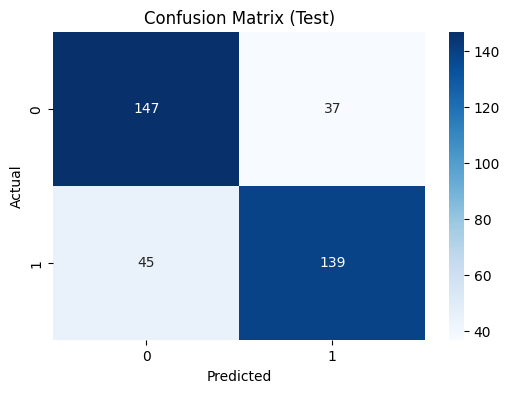

In [74]:
import seaborn as sns
cm = confusion_matrix(test_targets_np, test_preds_np)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Test)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()
